# take2

**GOAL**: Keep It Stupid Simple = KISS.

**Dependencies:**
 - [pocketknives](https://github.com/zjwilliams20/pocketknives)

**References:**
 1. [ilqgames/python](https://github.com/HJReachability/ilqgames/blob/master/python)

In [1]:
from time import perf_counter as pc

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import torch

from decentralized import split_agents
import decentralized as dec
import pocketknives

π = np.pi

In [2]:
%load_ext autoreload
%autoreload 1
%aimport decentralized.control, decentralized.dynamics, decentralized.cost, decentralized.problem, decentralized.util

In [3]:
%matplotlib widget
plt.rcParams['axes.grid'] = True

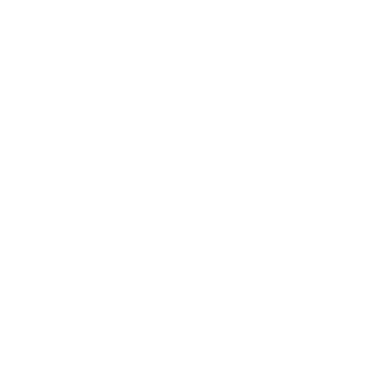

In [4]:
fig = plt.figure(figsize=(3.7, 3.7))
# fig = plt.figure()

In [5]:
def pos_mask(x_dims):
    """Return a mask that's true wherever there's an x or y position""" 
    return np.array([i % x_dims[0] < 2 for i in range(sum(x_dims))])

In [6]:
def plot_solve(X, J, x_goal, x_dims=None):
    """Plot the resultant trajectory on plt.gcf()"""

    if not x_dims:
        x_dims = [X.shape[1]]
        
    N = X.shape[0]
    t = np.arange(N) * dt
    
    X_split = split_agents(X, x_dims)
    x_goal_split = split_agents(x_goal.reshape(1,-1), x_dims)
    
    for Xi, xg in zip(X_split, x_goal_split):
        plt.scatter(Xi[:,0], Xi[:,1], c=t)
        plt.scatter(Xi[0,0], Xi[0,1], 80, 'g', 'x', label="$x_0$")
        plt.scatter(xg[0,0], xg[0,1], 80, 'r', 'x', label="$x_f$")
    
    plt.margins(0.1)
    plt.title(f"Final Cost: {J:.3g}")
    plt.draw()

## single-agent problem

In [7]:
dt = 0.1
N = 50

x = torch.tensor([-10, 10, 0], dtype=torch.float, requires_grad=True)
x_goal = torch.zeros((3, 1), dtype=torch.float).T

dynamics = dec.CarDynamics3D(dt)

Q = torch.diag(torch.tensor([1., 1, 0]))
Qf = 1000 * torch.eye(Q.shape[0])
R = torch.eye(2)
cost = dec.ReferenceCost(x_goal, Q, R, Qf)

prob = dec.ilqrProblem(dynamics, cost)
ilqr = dec.ilqrSolver(prob, N)
X, U, J = ilqr.solve(x)
plot_solve(X, J, x_goal.numpy())

0/50	J: 210000
1/50	J: 106051	μ: 0.5	Δ: 0.5
2/50	J: 4572.96	μ: 0.125	Δ: 0.25
3/50	J: 2783.66	μ: 0.015625	Δ: 0.125
4/50	J: 2511.76	μ: 0.000976562	Δ: 0.0625
5/50	J: 2329.04	μ: 3.05176e-05	Δ: 0.03125
6/50	J: 2322.72	μ: 0	Δ: 0.015625
7/50	J: 2271.32	μ: 0	Δ: 0.0078125
8/50	J: 2261.2	μ: 0	Δ: 0.00390625
9/50	J: 2258.84	μ: 0	Δ: 0.00195312


## multi-agent problem

### initializing the scene
Here, we define some initial positions within some distance of each other, and then rotate them about the origin by some random angle to hopefully create some interesting scenarios.

In [8]:
def paper_setup():
    """Hardcoded example with reasonable consistency eyeballed from 
       Potential-iLQR paper
    """
    x0 = torch.tensor([[0.5, 1.5, 0.1, 0,
                        2.5, 1.5, π, 0,
                        1.5, 1.3, π/2, 0]], 
                     dtype=torch.float, requires_grad=True).T
    x_goal = torch.tensor([[2.5, 1.5, 0, 0, 
                            0.5, 1.5, π, 0, 
                            1.5, 2.2, π/2, 0]]).T
    return x0, x_goal

def car_setup():
    """Same as paper_setup but using car dynamics"""
    x0, x_goal = paper_setup()
    car_mask = [i % 4 < 3 for i in range(x0.shape[0])]
    return x0[car_mask], x_goal[car_mask]

def bike_setup():
    """Same as paper_setup but using bike dynamics"""
    N_AGENTS = 3
    N_STATES = 5
    n_total_states = N_AGENTS * N_STATES
    bike_mask = [i % 5 < 4 for i in range(n_total_states)]
    
    x0, x_goal = paper_setup()
    x0_bike = torch.zeros(n_total_states, 1)
    x_goal_bike = torch.zeros_like(x0_bike)
    x0_bike[bike_mask] = x0
    x_goal_bike[bike_mask] = x_goal
    
    return x0_bike, x_goal_bike

def double_int_setup():
    x0, x_goal = paper_setup()
    theta_mask = [i % 4 == 2 for i in range(x0.shape[0])]
    with torch.no_grad():
        x0[theta_mask] = 0.0
        x_goal[theta_mask] = 0.0

    return x0, x_goal

def dec_test_setup():
    x0, x_goal = paper_setup()
    x0_other = torch.tensor([[5, 5, 0, 0,
                              6, 6, π/4, 0]]).T
    x_goal_other = torch.tensor([[6, 4, -π/2, 0,
                                  4, 6, π/4, 0]]).T
    
    x0 = torch.cat([x0, x0_other]) 
    x_goal = torch.cat([x_goal, x_goal_other])    
    
    return x0, x_goal

To be consistent between simulations, we normalize for the scale of the setup by computing the *energy*, or the sum of distances from the origin of the points. This should be the same for all runs.

In [9]:
def compute_energy(x, x_dims):
    """Determine the sum of distances from the origin"""
    return torch.sum(x[pos_mask(x_dims)].reshape(-1,2).norm(dim=1)).item()

def normalize_energy(x, x_dims, energy=10.0):
    """Zero-center the coordinates and then ensure the sum of 
       squared distances == energy
    """
    
    # Don't mutate x's data for this function, keep it pure.
    x = x.clone()
    n_agents = len(x_dims)
    center = x[pos_mask(x_dims)].reshape(-1, 2).mean(0)

    with torch.no_grad():
        x[pos_mask(x_dims)] -= center.tile(n_agents).reshape(-1,1)
        x[pos_mask(x_dims)] *= energy / compute_energy(x, x_dims)
    assert x.numel() == sum(x_dims)
    
    return x

def perturb_state(x, x_dims, var=0.5):
    """Add a little noise to the start to knock off perfect symmetries"""
    
    x = x.clone()
    with torch.no_grad():
        x[pos_mask(x_dims)] += var*torch.randn_like(x[pos_mask(x_dims)])
    
    return x

In [10]:
n_agents = 7
n_states = 4
n_controls = 2
ENERGY = 10.0

# x0, x_goal = paper_setup()
# x0, x_goal = car_setup()
# x0, x_goal = bike_setup()
# x0, x_goal = double_int_setup()
# x0, x_goal = dec_test_setup()
x0, x_goal = dec.random_setup(n_agents, n_states, min_sep=1.0, var=1.0)

x_dims = [n_states] * n_agents
u_dims = [2] * n_agents

x0 = normalize_energy(x0, x_dims, ENERGY)
x_goal = normalize_energy(x_goal, x_dims, ENERGY)
# x0 = perturb_state(x0, x_dims)

plt.clf()
plt.gca().set_aspect('equal')
X = torch.dstack([
    x0.reshape(n_agents, n_states).detach(), 
    x_goal.reshape(n_agents, n_states).detach()
]).swapaxes(1,2)
for i, Xi in enumerate(X):
    plt.annotate('', Xi[1,:2], Xi[0,:2], 
                 arrowprops=dict(facecolor=plt.cm.tab20.colors[2*i]))
pocketknives.set_bounds(X.reshape(-1, n_states), zoom=0.2)
plt.draw()

In [11]:
dt = 0.05
N = 50
tol = 1e-3
ids = [100 + i for i in range(n_agents)]

# dec._reset_ids()
model = dec.UnicycleDynamics4D
# model = dec.CarDynamics3D
# model = dec.BikeDynamics5D
# model = dec.DoubleIntDynamics4D
dynamics = dec.MultiDynamicalModel([model(dt, id_) for id_ in ids])

Q = 4 * torch.diag(torch.tensor([1., 1, 0, 0]))
# Qf = 1000 * torch.eye(Q.shape[0])
Qf = 1000 * torch.diag(torch.tensor([1., 1, 1, 1]))
R = torch.eye(2)

# radius = ENERGY / 20
radius = 0.25

goal_costs = [dec.ReferenceCost(x_goal_i, Q.clone(), R.clone(), Qf.clone(), id_) 
              for x_goal_i, id_ in zip(split_agents(x_goal.T, x_dims), ids)]
prox_cost = dec.ProximityCost(x_dims, radius)
game_cost = dec.GameCost(goal_costs, prox_cost)

prob = dec.ilqrProblem(dynamics, game_cost)

In [12]:
%%time
# %%prun
ilqr = dec.ilqrSolver(prob, N)
t0 = pc()
X, U, J = ilqr.solve(x0, tol=tol)

0/50	J: 47527.3
1/50	J: 5979.2	μ: 0.5	Δ: 0.5
2/50	J: 4018.17	μ: 0.125	Δ: 0.25
3/50	J: 3512.32	μ: 0.015625	Δ: 0.125
4/50	J: 3467.07	μ: 0.000976562	Δ: 0.0625
CPU times: user 21.2 s, sys: 0 ns, total: 21.2 s
Wall time: 21.2 s


In [13]:
plt.clf()
plot_solve(X, J, x_goal.numpy(), x_dims)

In [14]:
plt.clf()
plt.plot(dec.compute_pairwise_distance(X, x_dims).T)
plt.hlines(radius, *plt.xlim(), 'r', ls='--')
plt.draw()

In [15]:
costs = []
for xi, ui in zip(X, U):
    costs.append(game_cost(xi, ui).item())
plt.clf()
plt.plot(costs)
plt.draw()

## multi-agent receding horizon

In [17]:
rhc = dec.RecedingHorizonController(x0, ilqr, step_size=10)
U0 = torch.zeros((ilqr.N, ilqr.n_u))
for Xi, Ui, Ji in rhc.solve(U0, J_converge=10.0, tol=tol):
    plot_solve(Xi, Ji, x_goal.numpy(), x_dims)
    fig.canvas.draw()

--------------------------------------------------
Horizon 0
0/50	J: 61551
1/50	J: 7840.49	μ: 0.5	Δ: 0.5
2/50	J: 5957.58	μ: 0.125	Δ: 0.25
3/50	J: 4661.8	μ: 0.015625	Δ: 0.125
4/50	J: 4558.6	μ: 0.000976562	Δ: 0.0625
5/50	J: 4533.52	μ: 3.05176e-05	Δ: 0.03125
--------------------------------------------------
Horizon 1
0/50	J: 1775.76
1/50	J: 1740.43	μ: 0.5	Δ: 0.5
--------------------------------------------------
Horizon 2
0/50	J: 655.259
1/50	J: 647.808	μ: 0.5	Δ: 0.5
--------------------------------------------------
Horizon 3
0/50	J: 233.421
1/50	J: 225.839	μ: 0.5	Δ: 0.5
--------------------------------------------------
Horizon 4
0/50	J: 80.687
1/50	J: 75.1855	μ: 0.5	Δ: 0.5
--------------------------------------------------
Horizon 5
0/50	J: 28.0639
1/50	J: 25.3295	μ: 0.5	Δ: 0.5
--------------------------------------------------
Horizon 6
0/50	J: 10.7935
1/50	J: 9.66059	μ: 0.5	Δ: 0.5
Converged!


## decentralized multi-agent

In [16]:
graph = dec.define_inter_graph_threshold(X, n_agents, radius, x_dims, ids)
graph

{100: [100, 102, 103, 104, 105],
 101: [101, 102, 105, 106],
 102: [100, 101, 102, 103, 105],
 103: [100, 102, 103, 104, 105],
 104: [100, 103, 104, 106],
 105: [100, 101, 102, 103, 105, 106],
 106: [101, 104, 105, 106]}

In [32]:
X_dec, U_dec, J_dec = dec.solve_decentralized(prob, X, U, radius)

Agent 100: [100, 102, 103, 104, 105, 106]
0/50	J: 3131.07
1/50	J: 3127.16	μ: 0.5	Δ: 0.5
2/50	J: 3120.8	μ: 0.125	Δ: 0.25
Took 9.82 seconds
Agent 101: [101, 102, 103, 104, 106]
0/50	J: 3456.74
Failed line search, giving up.
Took 3.91 seconds
Agent 102: [100, 101, 102, 103, 104, 106]
0/50	J: 4010.25
Failed line search, giving up.
Took 3.22 seconds
Agent 103: [100, 101, 102, 103, 104, 106]
0/50	J: 4010.25
Failed line search, giving up.
Took 3.84 seconds
Agent 104: [100, 101, 102, 103, 104, 106]
0/50	J: 4010.25
Failed line search, giving up.
Took 3.67 seconds
Agent 105: [100, 105, 106]
0/50	J: 936.722
1/50	J: 930.937	μ: 0.5	Δ: 0.5
Took 2 seconds
Agent 106: [100, 101, 102, 103, 104, 105, 106]
0/50	J: 4273.97
Failed line search, giving up.
Took 3.8 seconds


In [17]:
plt.clf()
pocketknives.set_bounds(X[:,pos_mask(x_dims)].reshape(-1,2))

x0_split = dec.split_graph(x0.T, x_dims, graph)
U_split = dec.split_graph(U, u_dims, graph)

x_goal_agents = split_agents(x_goal.T, x_dims)
X_full = torch.zeros((N+1, n_agents*n_states))
U_full = torch.zeros((N, n_agents*n_controls))

for i, (subproblem, x0i, Ui, id_, x_goal_i) in enumerate(
    zip(prob.split(graph), x0_split, U_split, ids, x_goal_agents)
):    
    print("=" * 60 + f"\nProblem {i}: {subproblem.ids}")
    subsolver = dec.ilqrSolver(subproblem, N)
    
    t0 = pc()
    Xi, Ui, Ji = subsolver.solve(x0i, Ui, tol=tol)
    print(f"Took {pc() - t0:.3g} seconds")
    
    Xi_agent, Ui_agent = subproblem.extract(Xi, Ui, id_)
    X_full[:,i*n_states:(i+1)*n_states] = Xi_agent
    U_full[:,i*n_controls:(i+1)*n_controls] = Ui_agent
    
    plot_solve(Xi_agent, Ji, x_goal_i.numpy(), [n_states])
    fig.canvas.draw()

Problem 0: [100, 102, 103, 104, 105]
0/50	J: 3049.71
Took 2.74 seconds
Problem 1: [101, 102, 105, 106]
0/50	J: 837.249
Took 4.58 seconds
Problem 2: [100, 101, 102, 103, 105]
0/50	J: 3036.74
Took 2.87 seconds
Problem 3: [100, 102, 103, 104, 105]
0/50	J: 3049.71
Took 2.53 seconds
Problem 4: [100, 103, 104, 106]
0/50	J: 2888.8
Took 1.62 seconds
Problem 5: [100, 101, 102, 103, 105, 106]
0/50	J: 3297.19
Took 3.09 seconds
Problem 6: [101, 104, 105, 106]
0/50	J: 764.264
Took 1.86 seconds


## decentralized multi-agent receding horizon
Right now, it's centralized since one planner decides all control inputs. Decentralizing the problem means each agent decides independently what its control input should be. It does so in a way to take advantage of the interaction graph to speed up computation.

## animation

In [166]:
def setup(X, x_goal, x_dims, radius):
    plt.clf()
    
    n_agents = len(x_dims)
    ax = plt.gca()
    handles = []
    for i in range(n_agents):
        handles.append((
            plt.plot(0, c=plt.cm.tab20.colors[2*i], marker='o', markersize=4)[0],
            ax.add_artist(plt.Circle(np.nan, radius, color='k', fill=True, alpha=0.3, lw=2))
        ))
        
    for xg in split_agents(x_goal, x_dims):
        plt.scatter(xg[0,0], xg[0,1], c='r', marker='x', zorder=10)

    X_cat = np.vstack(split_agents(X, x_dims))
    pocketknives.set_bounds(X_cat, zoom=0.3)
    plt.draw()
    
    return handles
    
def animate(t, handles, X, x_dims, x_goal):
    """Animate the solution into a gif"""
    for (i, xi), hi in zip(enumerate(split_agents(X, x_dims)), handles):
        hi[0].set_xdata(xi[:t,0])
        hi[0].set_ydata(xi[:t,1])
        hi[1].set_center(xi[t-1,:2])
    plt.draw()
    

In [175]:
plt.clf()
handles = setup(X, x_goal.flatten(), x_dims, radius)
animate(-1, handles, X, x_dims, x_goal)

In [55]:
handles = setup(X, x_goal.flatten(), x_dims, radius)
anim = FuncAnimation(plt.gcf(), animate, frames=N+1, fargs=(handles, X, x_dims, x_goal))
anim.save('traj.gif', fps=5)

MovieWriter ffmpeg unavailable; using Pillow instead.
